# Init

In [1]:
!pip install stanza
!pip install scikit-learn # Install scikit-learn if you haven't already
!pip install gensim


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 18.8 MB/s eta 0:00:00


In [2]:
# Data handling
import pandas as pd
import json
import os
import re
import itertools
import time

# Natural Language Processing
import nltk
import stanza
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

# Machine Learning
import numpy as np
import concurrent.futures
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, NMF, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score

# Gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Joblib
from joblib import dump

# Google Colab
from google.colab import files

import numpy as np
import matplotlib.pyplot as plt



In [3]:
stanza.download('ro')
nlp = stanza.Pipeline('ro')
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('romanian'))
print(stop_words)
romanian_alphabet_regex = re.compile(r'[A-Za-zĂăÂâÎîȘșȚț]')

INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: ro (Romanian) ...


INFO:stanza:Downloaded file to /root/stanza_resources/ro/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: ro (Romanian):
| Processor | Package      |
----------------------------
| tokenize  | rrt          |
| pos       | rrt_nocharlm |
| lemma     | rrt_nocharlm |
| depparse  | rrt_nocharlm |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
/usr/local/lib/python3.10/dist-packages/stanza/models/tokenization/trainer.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loa

{'nou', 'mă', 'cita', 'putini', 'nostru', 'trei', 'avea', 'aceasta', 'cat', 'îl', 'sai', 'dată', 'oricît', 'atare', 'cite', 'ii', 'voastre', 'unul', 'acea', 'ţie', 'catre', 'uneia', 'săi', 'ului', 'cu', 'drept', 'aceştia', 'astea', 'i', 'oricum', 'deasupra', 'doi', 'el', 'cele', 'fiu', 'abia', 'voi', 'nimeni', 'către', 'peste', 'sale', 'căci', 'acest', 'cind', 'mîine', 'era', 'nu', 'inainte', 'câte', 'despre', 'acelea', 'aceia', 't', 'mereu', 'zi', 'pina', 'ţi', 'acesta', 'inca', 'altul', 'cîţi', 'nouă', 'se', 'aia', 'în', 'ci', 'acestui', 'aici', 'cărui', 'cine', 'citiva', 'puţin', 'după', 'eram', 'ala', 'tocmai', 'unele', 'cit', 'îi', 'alea', 'voastră', 'tăi', 'meu', 'noastre', 'avut', 'ma', 'multa', 'tot', 'toate', 'vouă', 'totul', 'incit', 'intr', 'mi', 'prima', 'numai', 'la', 'noi', 'ar', 'doilea', 'spre', 'alti', 'sa-ti', 'ne', 'acestei', 'parca', 'celor', 'cîtva', 'asta', 'dat', 'undeva', 'il', 'mai', 'suntem', 'mâine', 'apoi', 'atunci', 'vor', 'ei', 'care', 'deşi', 'ceea', 'pân

# Prep

In [4]:
test_data = {}
voc = {}

for i in range(5):
    # Download and load cleaned reviews
    os.system(f'wget -q "https://raw.githubusercontent.com/ACS-SII/proiect-2024-sentiment-analysis-study/refs/heads/main/new_set/cleaned_reviews_rating_{i+1}.json"')
    with open(f"cleaned_reviews_rating_{i+1}.json", "r") as f:
        test_data[i+1] = json.load(f)

    # Download and load vocabulary
    os.system(f'wget -q "https://raw.githubusercontent.com/ACS-SII/proiect-2024-sentiment-analysis-study/refs/heads/main/new_set/voc_rating_{i+1}.json"')
    with open(f"voc_rating_{i+1}.json", "r") as f:
        voc[i+1] = json.load(f)

    # # Optional: print confirmation
    # print(f"Loaded data for rating {i+1}:")
    # print("Sample review data:", test_data[:1])  # Show first entry as a sample
    # print("Sample vocabulary:", dict(list(voc.items())[:5]))  # Show first 5 entries as a sample


In [49]:
dict_pos = Counter(voc[4]) + Counter(voc[5])  # Positive combined vocabulary
dict_neg = Counter(voc[1]) + Counter(voc[2])   # Negative combined vocabulary

In [50]:
# dict_pos = dict(vocab_pos)
# dict_neg = dict(vocab_neg)

# Merge dictionaries and handle occurrences
merged_dict = {}
for word in set(dict_pos.keys()).union(dict_neg.keys()):
    occurrences_pos = dict_pos.get(word, 0)
    occurrences_neg = dict_neg.get(word, 0)
    merged_dict[word] = (occurrences_pos, occurrences_neg)


# Order the merged dictionary by maximum occurrence
sorted_merged_dict = dict(sorted(merged_dict.items(), key=lambda item: sum(item[1]), reverse=True))

# Display the ordered occurrences
# for word, counts in sorted_merged_dict.items():
#     print(f'{word}: {counts[0]} (positive), {counts[1]} (negative), Max Occurrence: {sum(counts)}')

# # Display the merged occurrences
# for word, counts in merged_dict.items():
#     print(f'{word}: {counts[0]} (positive), {counts[1]} (negative)')



In [51]:
print(sorted_merged_dict)

{'avea': (12269, 12185), 'de': (12913, 8980), 'fi': (11133, 7150), 'si': (7534, 4870), 'un': (6828, 4897), 'la': (5919, 5158), 'nu': (4935, 5598), 'in': (5513, 4194), 'său': (4782, 4507), 'produs': (4603, 2416), 'ca': (3359, 3652), 'mai': (4268, 2350), 'pe': (3333, 2911), 'cu': (3629, 2486), 'eu': (2947, 2644), 'el': (2866, 2571), 'pentru': (3114, 1543), 'sine': (2615, 1995), 'care': (2599, 1874), 'foarte': (3159, 1038), 'din': (2116, 1935), 'mult': (2073, 928), 'ce': (1518, 1199), 'tot': (1850, 817), 'bun': (1999, 502), 'dar': (1485, 994), 'putea': (1460, 927), 'pret': (1634, 740), 'meu': (1340, 867), 'vrea': (1097, 1027), 'al': (1078, 861), 's': (736, 1137), 'trebui': (953, 765), 'acela': (1054, 657), 'face': (836, 806), 'mare': (1116, 517), 'calitate': (1290, 338), 'și': (1041, 583), 'personal': (1126, 486), 'acesta': (796, 784), 'după': (470, 1061), 'bine': (1231, 273), 'acest': (800, 661), 'decathlon': (940, 508), 'în': (755, 598), 'a': (715, 586), 'copil': (887, 389), 'sau': (772

In [52]:
percentage_difference = {
    word: ((counts[0] - counts[1]) / ((counts[0] + counts[1]) / 2)) * 100
    for word, counts in sorted_merged_dict.items()
}

# Display the first 50 items in the sorted merged dictionary with percentage difference
for i, (word, counts) in enumerate(sorted_merged_dict.items()):
    if i < 50:
        diff_percentage = percentage_difference[word]
        print(f'{word}: {counts[0]} (positive), {counts[1]} (negative), Percentage Difference: {diff_percentage:.2f}%')
    else:
        break

avea: 12269 (positive), 12185 (negative), Percentage Difference: 0.69%
de: 12913 (positive), 8980 (negative), Percentage Difference: 35.93%
fi: 11133 (positive), 7150 (negative), Percentage Difference: 43.57%
si: 7534 (positive), 4870 (negative), Percentage Difference: 42.95%
un: 6828 (positive), 4897 (negative), Percentage Difference: 32.94%
la: 5919 (positive), 5158 (negative), Percentage Difference: 13.74%
nu: 4935 (positive), 5598 (negative), Percentage Difference: -12.59%
in: 5513 (positive), 4194 (negative), Percentage Difference: 27.18%
său: 4782 (positive), 4507 (negative), Percentage Difference: 5.92%
produs: 4603 (positive), 2416 (negative), Percentage Difference: 62.32%
ca: 3359 (positive), 3652 (negative), Percentage Difference: -8.36%
mai: 4268 (positive), 2350 (negative), Percentage Difference: 57.96%
pe: 3333 (positive), 2911 (negative), Percentage Difference: 13.52%
cu: 3629 (positive), 2486 (negative), Percentage Difference: 37.38%
eu: 2947 (positive), 2644 (negative),

In [44]:
# Filter for words with a minimum appearance of 3 and sort by absolute percentage difference
filtered_sorted_percentage_difference = sorted(
    {
        word: diff for word, diff in percentage_difference.items()
        if sum(sorted_merged_dict[word]) >= 3
    }.items(),
    key=lambda item: abs(item[1]),
    reverse=True
)

# Print the filtered and sorted results
print("Word\t\tPercentage Difference")
print("=" * 40)
for word, diff in filtered_sorted_percentage_difference[:50]:
    print(f"{word}\t\t{diff:.2f}%")


Word		Percentage Difference
spună		-200.00%
scoata		-200.00%
rusin		-200.00%
comandat		-200.00%
factura		-200.00%
odata		-200.00%
cută		-200.00%
niman		-200.00%
omite		-200.00%
inconfortabil		-200.00%
furt		-200.00%
ghiseu		-200.00%
imbinare		-200.00%
inacceptabil		-200.00%
iubitor		200.00%
trimisă		-200.00%
capsă		-200.00%
totală		-200.00%
opc		-200.00%
nedescris		-200.00%
cică		-200.00%
jumata		-200.00%
coș		-200.00%
negasi		-200.00%
incorect		-200.00%
desumfla		-200.00%
director		-200.00%
ploist		-200.00%
minciună		-200.00%
shorts		200.00%
minti		-200.00%
blocată		-200.00%
frumusete		-200.00%
inestetic		-200.00%
l		-200.00%
pocni		-200.00%
gonflabilă		-200.00%
ovidiu		200.00%
mentineti		200.00%
supapă		-200.00%
inapoia		-200.00%
serveasca		-200.00%
chain		-200.00%
lipică		-200.00%
racoros		200.00%
unghie		-200.00%
ras		-200.00%
crapatură		-200.00%
buletin		-200.00%
arcadă		-200.00%


In [10]:
def remove_vocab(sett,rvocab):
  nset=list()
  for doc in sett:
    tokens = doc.split()
    tokens = [w for w in tokens if w not in rvocab]
    tokens = ' '.join(tokens)
    nset.append(tokens)
  return nset

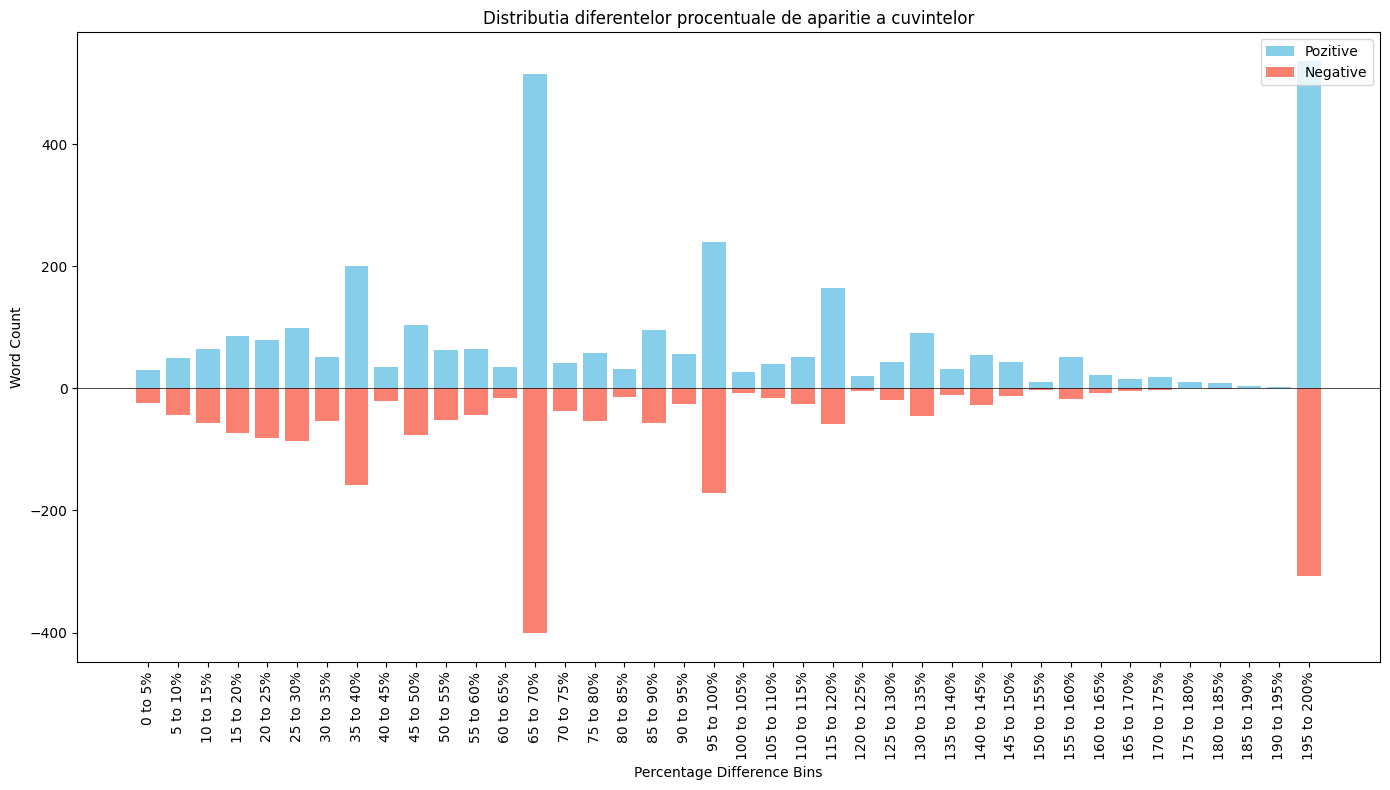

In [53]:


# Filter percentage_difference to include only words with at least 3 appearances
filtered_percentage_difference = {
    word: diff for word, diff in percentage_difference.items()
    if sum(sorted_merged_dict[word]) >= 3
}

# Define bins from 0 to 200 in 5% intervals
bins = np.arange(0, 205, 5)  # Create bins from 0 to 200 in steps of 5
bin_labels = [f"{bins[i]} to {bins[i+1]}%" for i in range(len(bins)-1)]  # Labels for bins

# Initialize dictionaries to count positive and negative occurrences in each bin
positive_counts = {label: 0 for label in bin_labels}
negative_counts = {label: 0 for label in bin_labels}

# Bin each percentage difference into positive and negative categories
for word, diff in filtered_percentage_difference.items():
    abs_diff = abs(diff)  # Use absolute difference for binning
    bin_index = np.digitize(abs_diff, bins,right=True) - 1  # Find bin index based on absolute value

    if 0 <= bin_index < len(bin_labels):  # Ensure index is within range
        if diff >= 0:
            positive_counts[bin_labels[bin_index]] += 1
        else:
            negative_counts[bin_labels[bin_index]] += 1

# Convert counts to lists for plotting
positive_counts_values = list(positive_counts.values())
negative_counts_values = [-count for count in negative_counts.values()]  # Negative for plotting below axis

# Plot the bar chart with positive and negative counts centered on each x-axis tick
x = np.arange(len(bin_labels))  # x-axis positions for each bin

plt.figure(figsize=(14, 8))
plt.bar(x, positive_counts_values, color='skyblue', label="Pozitive")
plt.bar(x, negative_counts_values, color='salmon', label="Negative")
plt.xticks(x, bin_labels, rotation=90)  # Set x-ticks to bin labels and rotate for readability
plt.axhline(0, color='black', linewidth=0.5)  # Add a baseline at y=0
plt.xlabel("Percentage Difference Bins")
plt.ylabel("Word Count")
plt.title("Distributia diferentelor procentuale de aparitie a cuvintelor")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


In [11]:
def remove_vocab_one(doc,rvocab):
  tokens = doc.split()
  tokens = [w for w in tokens if w not in rvocab]
  tokens = ' '.join(tokens)
  return tokens

In [12]:
def rem_words(perc):
  c=0

  wordds=[]

  for word in stop_words:
    lem=nlp(word)
    lem=lem.sentences[0]
    lem=lem.words[0]
    lem=lem.lemma
    if lem in sorted_merged_dict :
      if abs(percentage_difference[lem])<perc and sum(sorted_merged_dict[lem])>2:
        # print(lem+' '+word+ ' '+str(percentage_difference[lem]))
        c+=1;
        wordds.append(word)

  print(c)
  # print(wordds)
  return wordds

In [13]:
torem=rem_words(5*10)

250


In [14]:
print(len(dict_pos))
print(len(dict_neg))

11200
9967


In [15]:
print(dict_pos)

Counter({'de': 12913, 'avea': 12269, 'fi': 11133, 'si': 7534, 'un': 6828, 'la': 5919, 'in': 5513, 'nu': 4935, 'său': 4782, 'produs': 4603, 'mai': 4268, 'cu': 3629, 'ca': 3359, 'pe': 3333, 'foarte': 3159, 'pentru': 3114, 'eu': 2947, 'el': 2866, 'sine': 2615, 'care': 2599, 'din': 2116, 'mult': 2073, 'bun': 1999, 'tot': 1850, 'pret': 1634, 'ce': 1518, 'dar': 1485, 'putea': 1460, 'meu': 1340, 'calitate': 1290, 'bine': 1231, 'personal': 1126, 'mare': 1116, 'vrea': 1097, 'al': 1078, 'acela': 1054, 'și': 1041, 'trebui': 953, 'decathlon': 940, 'copil': 887, 'face': 836, 'recomanda': 827, 'acest': 800, 'acesta': 796, 'ok': 789, 'sau': 772, 'în': 755, 's': 736, 'a': 715, 'tu': 705, 'gasi': 681, 'pt': 664, 'multumi': 659, 'timp': 617, 'plăcea': 586, 'bicicletă': 585, 'stoc': 581, 'usor': 575, 'alt': 573, 'dori': 572, 'client': 561, 'cand': 560, 'articol': 558, 'folosi': 553, 'an': 530, 'dacă': 529, 'doar': 529, 'putin': 526, 'raft': 525, 'mic': 518, 'cel': 503, 'amabil': 501, 'cumpara': 480, 'cas

In [16]:
vocab_fin=dict_pos+dict_neg

In [17]:
print(len(vocab_fin))
print(vocab_fin)

15530
Counter({'avea': 24454, 'de': 21893, 'fi': 18283, 'si': 12404, 'un': 11725, 'la': 11077, 'nu': 10533, 'in': 9707, 'său': 9289, 'produs': 7019, 'ca': 7011, 'mai': 6618, 'pe': 6244, 'cu': 6115, 'eu': 5591, 'el': 5437, 'pentru': 4657, 'sine': 4610, 'care': 4473, 'foarte': 4197, 'din': 4051, 'mult': 3001, 'ce': 2717, 'tot': 2667, 'bun': 2501, 'dar': 2479, 'putea': 2387, 'pret': 2374, 'meu': 2207, 'vrea': 2124, 'al': 1939, 's': 1873, 'trebui': 1718, 'acela': 1711, 'face': 1642, 'mare': 1633, 'calitate': 1628, 'și': 1624, 'personal': 1612, 'acesta': 1580, 'după': 1531, 'bine': 1504, 'acest': 1461, 'decathlon': 1448, 'în': 1353, 'a': 1301, 'copil': 1276, 'sau': 1263, 'casă': 1194, 'cand': 1186, 'bicicletă': 1181, 'tu': 1152, 'stoc': 1089, 'recomanda': 1081, 'raft': 1079, 'timp': 1074, 'pt': 1067, 'doar': 1023, 'alt': 1016, 'nici': 1014, 'iar': 1002, 'ok': 970, 'cumpara': 947, 'gasi': 944, 'client': 939, 'dacă': 938, 'an': 874, 'cel': 868, 'da': 849, 'dori': 849, 'putin': 847, 'folosi': 

In [18]:
# Convert `torem` list to a set for efficient lookups
torem_set = set(torem)

# Filter `vocab_fin` to keep words with occurrences >= 3 and not in `torem`
filtered_vocab = {word: count for word, count in vocab_fin.items()
                  if count >= 3 and word not in torem_set}


In [19]:
print(len(filtered_vocab))

5609


In [20]:
def filter_vocab(data, voc):
  # Filter each review in `data` by including only words present in `voc`
    filtered_data = []
    for review in data:
        # Split review into words, filter words not in `voc`, and rejoin to form the cleaned review
        filtered_review = " ".join(word for word in review.split() if word in voc)
        filtered_data.append(filtered_review)
    return filtered_data

In [21]:
data_pos=test_data[4]+test_data[5]
data_neg=test_data[1]+test_data[2]

data_clean_pos=filter_vocab(data_pos,filtered_vocab)
data_clean_neg=filter_vocab(data_neg,filtered_vocab)

data_len=min(len(data_clean_pos),len(data_clean_neg))
data_clean_pos = data_clean_pos[:data_len]
data_clean_neg = data_clean_neg[:data_len]

# data_clean_pos = data_clean_pos[:10000]
# data_clean_neg = data_clean_neg[:10000]

y_opt = [1] * len(data_clean_pos) + [0] * len(data_clean_neg)
opt_set = data_clean_pos + data_clean_neg

print(len(data_clean_neg))
print(len(data_clean_pos))

train_texts, test_texts, train_labels, test_labels = train_test_split(opt_set, y_opt, test_size=0.2, random_state=42)

4257
4257


# Test

In [ ]:
# opt_set = test_train_neg_clean + test_test_neg_clean + test_test_pos_clean + test_train_pos_clean

# y_opt = np.array([0 for _ in range(7500)] + [1 for _ in range(7500)])

vectorizer = CountVectorizer()
X_opt = vectorizer.fit_transform(opt_set)
print(X_opt.shape)

In [ ]:


# Training and saving the model with DM
def train_and_save_dm_model(tagged_data, model_path):
    model_dm = Doc2Vec(vector_size=300, window=5, min_count=2, workers=4, epochs=20, dm=1)
    model_dm.build_vocab(tagged_data)
    model_dm.train(tagged_data, total_examples=model_dm.corpus_count, epochs=model_dm.epochs)
    model_dm.save(model_path)
    print(f"Doc2Vec DM model saved to {model_path}")

# Training and saving the model with DBOW
def train_and_save_dbow_model(tagged_data, model_path):
    model_dbow = Doc2Vec(vector_size=300, window=5, min_count=2, workers=4, epochs=20, dm=0)
    model_dbow.build_vocab(tagged_data)
    model_dbow.train(tagged_data, total_examples=model_dbow.corpus_count, epochs=model_dbow.epochs)
    model_dbow.save(model_path)
    print(f"Doc2Vec DBOW model saved to {model_path}")



# Prepare tagged documents
tagged_data = [TaggedDocument(words=text.split(), tags=[f'DOC_{i}']) for i, text in enumerate(opt_set)]
# Example usage
train_and_save_dm_model(tagged_data, 'doc2vec_dm.model')
train_and_save_dbow_model(tagged_data, 'doc2vec_dbow.model')

In [ ]:
d2v_model_dm = Doc2Vec.load('doc2vec_dm.model')
print("Doc2Vec DM model loaded successfully.")

# Load the Doc2Vec DBOW model
d2v_model_dbow = Doc2Vec.load('doc2vec_dbow.model')
print("Doc2Vec DBOW model loaded successfully.")

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
X_opt_tfidf = tfidf_vectorizer.fit_transform(opt_set)

X_opt_tfidf = X_opt_tfidf.toarray()

tagged_docs = [TaggedDocument(words=doc.split(), tags=[str(i)]) for i, doc in enumerate(opt_set)]

X_opt_dm = np.array([d2v_model_dm.infer_vector(doc.words) for doc in tagged_docs])
X_opt_dbow = np.array([d2v_model_dbow.infer_vector(doc.words) for doc in tagged_docs])


In [ ]:
vectorizer = CountVectorizer()

    # Fit the vectorizer on the documents to get the vocabulary
vectorizer.fit(opt_set)

    # Get the vocabulary
final_vocab = vectorizer.vocabulary_

In [ ]:
print(len(final_vocab))

In [ ]:
#verifica daca vec are elem negative
def pos_vec(X_train,X_test):
  if np.any(X_train < 0) or np.any(X_test < 0):
    offset = np.abs(np.min(X_train)) + 1
    X_train_pos = X_train + offset
    X_test_pos = X_test + offset
  else:
    X_train_pos = X_train
    X_test_pos = X_test
  return X_train_pos, X_test_pos

In [ ]:
# opt_set = test_train_neg_clean + test_test_neg_clean + test_test_pos_clean + test_train_pos_clean

# y_opt = np.array([0 for _ in range(7500)] + [1 for _ in range(7500)])

vectorizer = CountVectorizer()
X_opt = vectorizer.fit_transform(opt_set)
X_opt=X_opt.toarray()

In [ ]:
def run_cml(feat,dim,mod):#,test_train_neg_clean , test_train_pos_clean , test_test_neg_clean , test_test_pos_clean):
  print("run:", feat, ' ', dim ,' ',mod)
  start_time = time.time()

  for n in range(1):
    match feat:
      case "bow":
        X_train, X_test, y_train, y_test = train_test_split(X_opt, y_opt, test_size=0.2, random_state=42)
        nn=0
      case "tfidf":
        X_train, X_test, y_train, y_test = train_test_split(X_opt_tfidf, y_opt, test_size=0.2, random_state=42)
        nn=1
      case "w2v":
        X_train, X_test, y_train, y_test = train_test_split(X_opt_w2v_a, y_opt, test_size=0.2, random_state=42)
        nn=0
      case "d2v_dm":
        X_train, X_test, y_train, y_test = train_test_split(X_opt_dm, y_opt, test_size=0.2, random_state=42)
        nn=1
      case "d2v_dbow":
        X_train, X_test, y_train, y_test = train_test_split(X_opt_dbow, y_opt, test_size=0.2, random_state=42)
        nn=4

    if not isinstance(X_train, np.ndarray):
        X_train.toarray()
    if not isinstance(X_test, np.ndarray):
        X_test.toarray()

    if feat=="bow" or feat=="tfidf":
      comp=500
    else:
      comp=100
    match dim:
      case "pca":
        pca = PCA(n_components=comp)  # Adjust n_components as needed

        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)

      case "nmf":
        # X_train, X_test = pos_vec(X_train,X_test)

        # nmf = NMF(n_components=comp, random_state=42)

        # X_train = nmf.fit_transform(X_train)
        # X_test = nmf.transform(X_test)

        X_train = nmf_reps[nn][1]
        X_test = nmf_reps[nn][2]
        y_train = nmf_reps[nn][3]
        y_test = nmf_reps[nn][4]

      case "lsa":
        lsa = TruncatedSVD(n_components=comp)

        X_train = lsa.fit_transform(X_train)
        X_test = lsa.transform(X_test)

      case "nonee":
        print('none')

    match mod:
      case "mnb":
        X_train, X_test = pos_vec(X_train,X_test)
        model=MultinomialNB(alpha=3.35)
      case "bnb":
        X_train, X_test = pos_vec(X_train,X_test)
        model=BernoulliNB(alpha=0.4058,binarize=0.4769)
      # case "gnb":
      #   model=GaussianNB(var_smoothing=9.8074e-05)
      # case "cnb":
      #   X_train, X_test = pos_vec(X_train,X_test)
      #   model=ComplementNB(alpha=3.3186,norm=False)
      case "lr":
        model = LogisticRegression(
            penalty='elasticnet',
            C=0.02,
            solver='saga',
            max_iter=455,
            tol=0.002,
            fit_intercept=True,
            class_weight=None,
            l1_ratio=0.7
        )
      case "rf":
        model = RandomForestClassifier(
            n_estimators=302,
            min_samples_split=2,
            min_samples_leaf=1,
            max_features='sqrt',
            criterion='gini',
            # random_state=42
        )
      case "svm":
        model = LinearSVC(
            C=0.0271,
            penalty='l2',
            dual=False,
            tol=0.0377,
            max_iter=9550,
            loss='squared_hinge',
            fit_intercept=True,
            intercept_scaling=0.183,
            random_state=42
        )

      case "knn":
        model = KNeighborsClassifier(
            n_neighbors=18,
            weights='uniform',
            algorithm='auto',
            leaf_size=25,
            p=1,
            metric='manhattan'
        )
      # case "wknn":
      #   model=KNeighborsClassifier(n_neighbors=5, weights='distance', metric='euclidean')
      # case _:
      #   print("numere2")
      #   break
      case _:
        print("Invalid feature type:", feat)
        return None, None, None


    model.fit(X_train, y_train)

    # Save the model to a file
    filename=mod+'_'+feat+'_model.joblib'
    dump(model, filename)
    # files.download(filename)


    # Evaluate model
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Get the runtime
    runtime = time.time() - start_time

  return acc, f1, runtime

In [ ]:
# List of function calls for all combinations
function_calls = []

# Define all possible combinations of feat, dim, and model
feats = [
        "bow",
        "tfidf",
         "d2v_dm",
        #  "d2v_dbow",
        #  "w2v"
         ]

dims = [
        "nonee",
        "pca",
        # "nmf",
        "lsa"
        ]

models = [
          "mnb",
          # "bnb",
          # "gnb",
          # "cnb",
          "lr",
          "rf",
          "svm",
          "knn",
          # "wknn"
          ]


# Function to be used by the executor
def process_combination(combination):
    feat, dim, model_name = combination
    acc, f1, runtime = run_cml(feat, dim, model_name)
    return {
        'feature': feat,
        'dimensionality': dim,
        'model': model_name,
        'accuracy': acc,
        'f1_score': f1,
        'runtime': runtime
    }
def runn_cml():
  # Create a list of all combinations
  combinations = list(itertools.product(feats, dims, models))

  results = []

  # Run the combinations in parallel
  with concurrent.futures.ThreadPoolExecutor() as executor:
      future_to_combination = {executor.submit(process_combination, comb): comb for comb in combinations}
      for future in concurrent.futures.as_completed(future_to_combination):
          result = future.result()
          results.append(result)

  # Print all results
  for result in results:
      print(result)



In [ ]:
runn_cml()

# Stats

In [22]:
raw_data = {}
for i in range(5):
    # Download and load cleaned reviews
    os.system(f'wget -q "https://raw.githubusercontent.com/ACS-SII/proiect-2024-sentiment-analysis-study/refs/heads/main/new_set/reviews_rating_{i+1}.json"')
    with open(f"reviews_rating_{i+1}.json", "r") as f:
        raw_data[i+1] = json.load(f)


In [23]:

# Function to eliminate NaN values
def clean_data(data):
    # Use pandas to filter out NaN values
    return [item for item in data if pd.notna(item)]

# Clean each list in raw_data
for key in raw_data.keys():
    raw_data[key] = clean_data(raw_data[key])

# Print cleaned raw_data to verify
for key, value in raw_data.items():
    print(f"Key: {key}, Number of Reviews: {len(value)}")

Key: 1, Number of Reviews: 1896
Key: 2, Number of Reviews: 2361
Key: 3, Number of Reviews: 5744
Key: 4, Number of Reviews: 3809
Key: 5, Number of Reviews: 6196


In [24]:

# Modified function to superpose histograms
def plot_length_distribution_superposed(data1, data2, data3, labels):
    # Calculate the lengths of each string in the datasets
    lengths1 = [len(item.split()) for item in data1 if len(item.split()) > 0]
    lengths2 = [len(item.split()) for item in data2 if len(item.split()) > 0]
    lengths3 = [len(item.split()) for item in data3 if len(item.split()) > 0]

    # Create the histogram with log-scaled bins
    bins = np.logspace(np.log10(1), np.log10(max(max(lengths1), max(lengths2), max(lengths3))), 50)

    # Plot the histograms
    plt.hist(lengths1, bins=bins, color='lightgray', alpha=0.6, label=labels[0], edgecolor='black')
    plt.hist(lengths2, bins=bins, color='green', alpha=0.6, label=labels[1], edgecolor='black')
    plt.hist(lengths3, bins=bins, color='red', alpha=0.6, label=labels[2], edgecolor='black')

    # Set the x-axis to a logarithmic scale
    plt.xscale('log')

    # Add labels, title, and legend
    plt.xlabel('Length of Strings (Log Scale)')
    plt.ylabel('Frequency')
    plt.title('Distributia dimensiunilor documentelor suprapuse')
    plt.legend()

    # Show the grid with dashed lines
    plt.grid(True, which="both", ls="--", linewidth=0.5)

    # Show the plot
    plt.show()


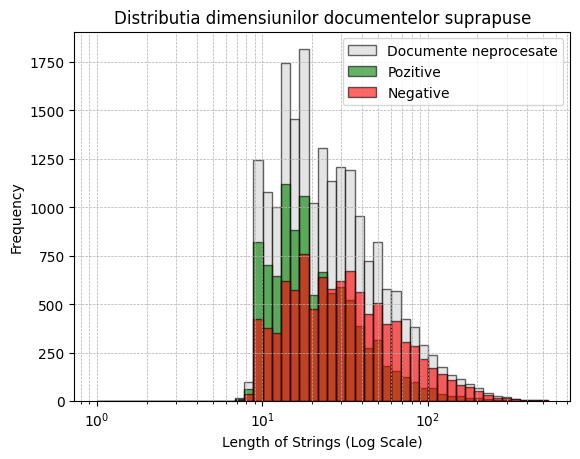

In [25]:

# Data combinations
data1 = test_data[1] + test_data[2] + test_data[3] + test_data[4] + test_data[5]
data2 = test_data[4] + test_data[5]
data3 = test_data[1] + test_data[2] + test_data[3]
# Plot the superposed distributions
plot_length_distribution_superposed(data1, data2, data3,
                                    ['Documente neprocesate', 'Pozitive', 'Negative'])

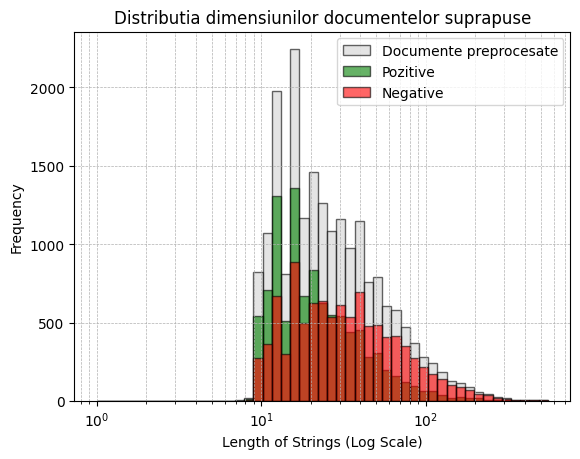

In [26]:

# Data combinations
data1 = raw_data[1] + raw_data[2] + raw_data[3] + raw_data[4] + raw_data[5]
data2 = raw_data[4] + raw_data[5]
data3 = raw_data[1] + raw_data[2] + raw_data[3]
# Plot the superposed distributions
plot_length_distribution_superposed(data1, data2, data3,
                                    ['Documente preprocesate', 'Pozitive', 'Negative'])

In [27]:


# Modified function to superpose histograms for 5 ratings plus total
def plot_length_distribution_superposed_6(data1, data2, data3, data4, data5, total_data, labels):
    # Calculate the lengths of each string in the datasets
    lengths1 = [len(item.split()) for item in data1 if len(item.split()) > 0]
    lengths2 = [len(item.split()) for item in data2 if len(item.split()) > 0]
    lengths3 = [len(item.split()) for item in data3 if len(item.split()) > 0]
    lengths4 = [len(item.split()) for item in data4 if len(item.split()) > 0]
    lengths5 = [len(item.split()) for item in data5 if len(item.split()) > 0]
    total_lengths = [len(item.split()) for item in total_data if len(item.split()) > 0]

    # Create the histogram with log-scaled bins
    max_length = max(max(lengths1), max(lengths2), max(lengths3), max(lengths4), max(lengths5), max(total_lengths))
    bins = np.logspace(np.log10(1), np.log10(max_length), 50)

    # Plot the histograms
    plt.figure(figsize=(10, 6))  # Set the figure size

    plt.hist(lengths1, bins=bins, color='skyblue', alpha=0.6, label=labels[0], edgecolor='black')
    plt.hist(lengths2, bins=bins, color='orange', alpha=0.6, label=labels[1], edgecolor='black')
    plt.hist(lengths3, bins=bins, color='green', alpha=0.6, label=labels[2], edgecolor='black')
    plt.hist(lengths4, bins=bins, color='purple', alpha=0.6, label=labels[3], edgecolor='black')
    plt.hist(lengths5, bins=bins, color='red', alpha=0.6, label=labels[4], edgecolor='black')
    plt.hist(total_lengths, bins=bins, color='black', alpha=0.4, label=labels[5], edgecolor='black')

    # Set the x-axis to a logarithmic scale
    plt.xscale('log')

    # Add labels, title, and legend
    plt.xlabel('Length of Strings (Log Scale)')
    plt.ylabel('Frequency')
    plt.title('Comparative Length Distribution of Document Sets (1-5 Star Ratings and Total)')
    plt.legend()

    # Show the grid with dashed lines
    plt.grid(True, which="both", ls="--", linewidth=0.5)

    # Show the plot
    plt.show()



In [28]:


# Modified function to superpose histograms for 5 ratings
def plot_length_distribution_stacked(data1, data2, data3, data4, data5, labels):
    # Calculate the lengths of each string in the datasets
    lengths1 = [len(item.split()) for item in data1 if len(item.split()) > 0]
    lengths2 = [len(item.split()) for item in data2 if len(item.split()) > 0]
    lengths3 = [len(item.split()) for item in data3 if len(item.split()) > 0]
    lengths4 = [len(item.split()) for item in data4 if len(item.split()) > 0]
    lengths5 = [len(item.split()) for item in data5 if len(item.split()) > 0]

    # Create the histogram with log-scaled bins
    max_length = max(max(lengths1), max(lengths2), max(lengths3), max(lengths4), max(lengths5))
    bins = np.logspace(np.log10(1), np.log10(max_length), 50)

    # Prepare the data for stacked histogram
    hist_data = [lengths1, lengths2, lengths3, lengths4, lengths5]

    # Create the stacked histogram
    plt.figure(figsize=(10, 8))  # Set the figure size

    plt.hist(hist_data, bins=bins, stacked=True,
             color=['skyblue', 'orange', 'green', 'purple', 'red'],
             alpha=0.6,  # Set a single alpha value for all bars
             label=labels, edgecolor='black')

    # Set the x-axis to a logarithmic scale
    plt.xscale('log')

    # Add labels, title, and legend
    plt.xlabel('Length of Strings (Log Scale)')
    plt.ylabel('Frequency')
    plt.title('Distributia lungimilor documentelor impartite pe scor')
    plt.legend()

    # Show the grid with dashed lines
    plt.grid(True, which="both", ls="--", linewidth=0.5)

    # Show the plot
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()

# Example usage (replace with your actual data)
# plot_length_distribution_stacked(data1, data2, data3, data4, data5, ['1 Star', '2 Star', '3 Star', '4 Star', '5 Star'])


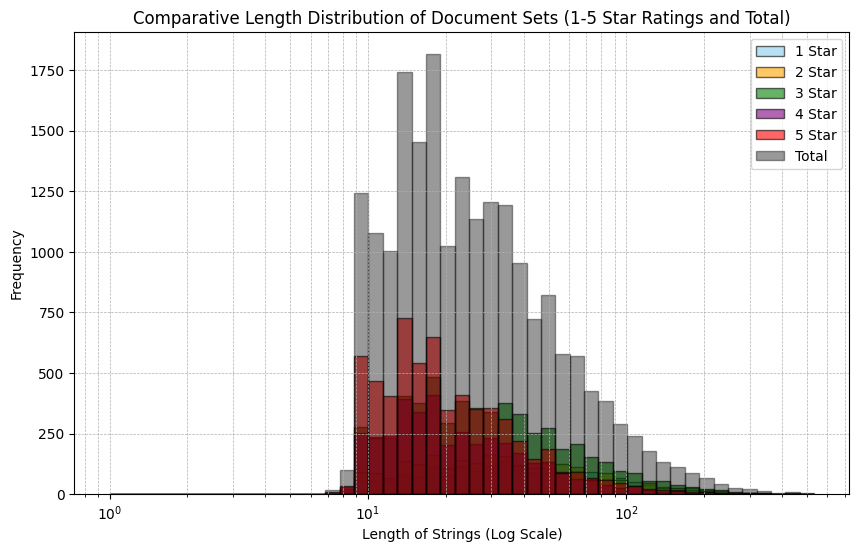

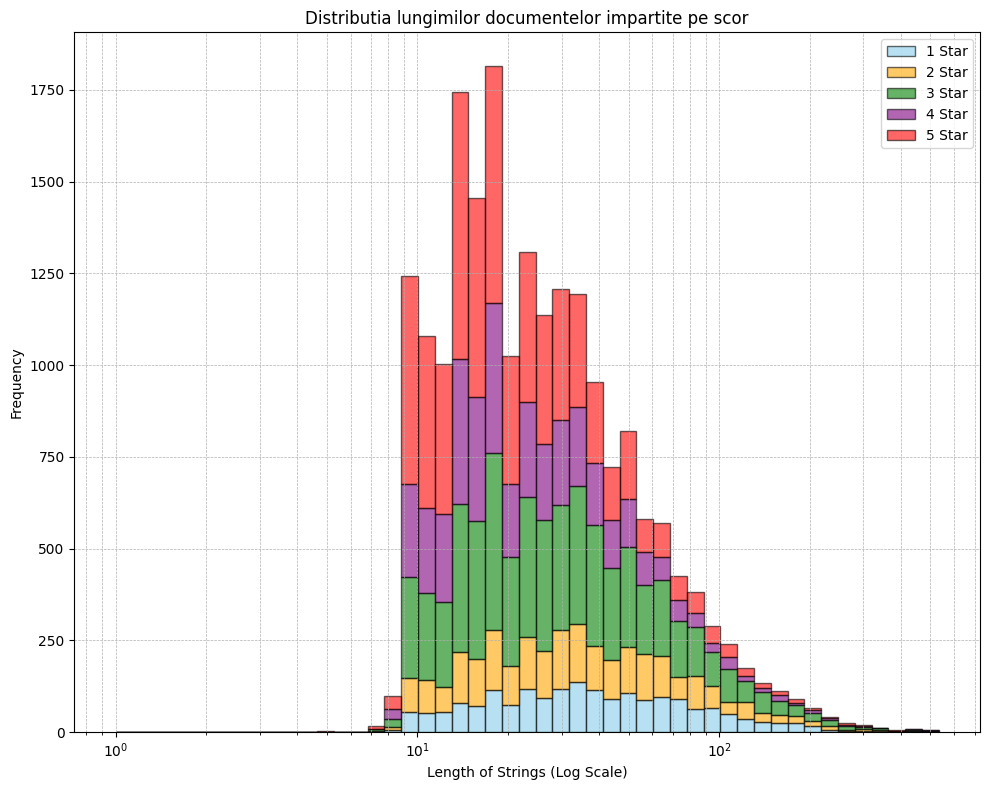

In [29]:

# Data for each rating category
data1 = test_data[1]
data2 = test_data[2]
data3 = test_data[3]
data4 = test_data[4]
data5 = test_data[5]

# Total data for all ratings combined
total_data = (test_data[1] + test_data[2] + test_data[3] + test_data[4] + test_data[5])
# Plot the superposed distributions
plot_length_distribution_superposed_6(data1, data2, data3, data4, data5, total_data,
                                      ['1 Star', '2 Star', '3 Star', '4 Star', '5 Star', 'Total'])
plot_length_distribution_stacked(data1, data2, data3, data4, data5,
                                      ['1 Star', '2 Star', '3 Star', '4 Star', '5 Star'])

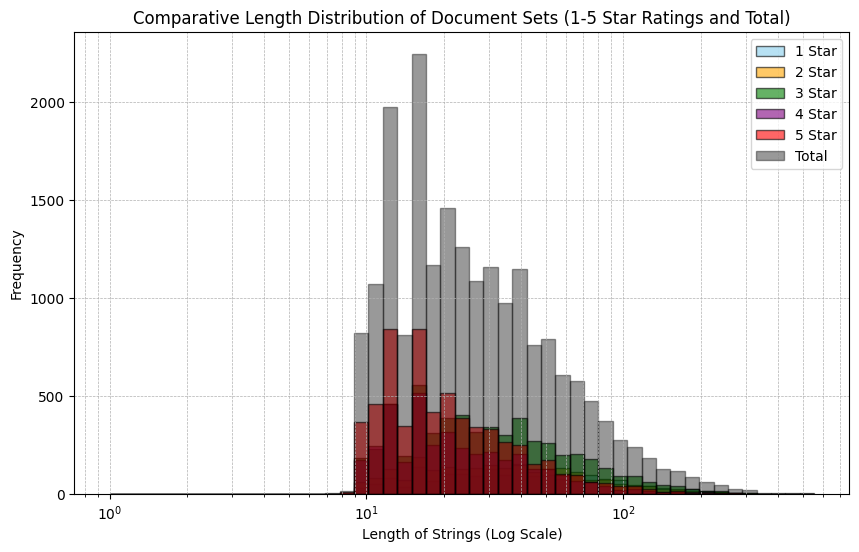

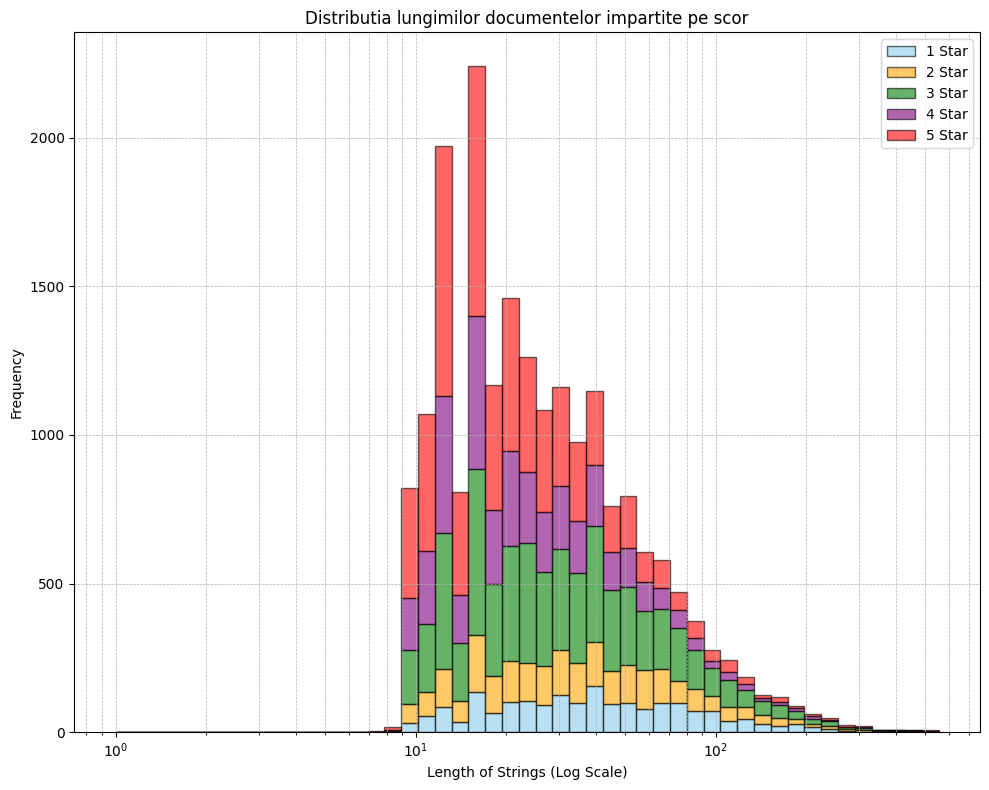

In [30]:
data1=raw_data[1]
data2=raw_data[2]
data3=raw_data[3]
data4=raw_data[4]
data5=raw_data[5]
total_data=raw_data[1]+raw_data[2]+raw_data[3]+raw_data[4]+raw_data[5]
plot_length_distribution_superposed_6(data1, data2, data3, data4, data5, total_data,
                                      ['1 Star', '2 Star', '3 Star', '4 Star', '5 Star', 'Total'])
plot_length_distribution_stacked(data1, data2, data3, data4, data5,
                                      ['1 Star', '2 Star', '3 Star', '4 Star', '5 Star'])

In [31]:
# Presupunând că 'test_data' și 'raw_data' sunt definite și accesibile

print(f"Număr de documente test_data cu 1 stea: {len(test_data[1])}")  # Afișează numărul de recenzii cu 1 stea din 'test_data'
print(f"Număr de documente test_data cu 2 stele: {len(test_data[2])}")  # Afișează numărul de recenzii cu 2 stele din 'test_data'
print(f"Număr de documente test_data cu 3 stele: {len(test_data[3])}")  # Afișează numărul de recenzii cu 3 stele din 'test_data'
print(f"Număr de documente test_data cu 4 stele: {len(test_data[4])}")  # Afișează numărul de recenzii cu 4 stele din 'test_data'
print(f"Număr de documente test_data cu 5 stele: {len(test_data[5])}")  # Afișează numărul de recenzii cu 5 stele din 'test_data'

print(f"Număr de documente raw_data cu 1 stea: {len(raw_data[1])}")  # Afișează numărul de recenzii cu 1 stea din 'raw_data'
print(f"Număr de documente raw_data cu 2 stele: {len(raw_data[2])}")  # Afișează numărul de recenzii cu 2 stele din 'raw_data'
print(f"Număr de documente raw_data cu 3 stele: {len(raw_data[3])}")  # Afișează numărul de recenzii cu 3 stele din 'raw_data'
print(f"Număr de documente raw_data cu 4 stele: {len(raw_data[4])}")  # Afișează numărul de recenzii cu 4 stele din 'raw_data'
print(f"Număr de documente raw_data cu 5 stele: {len(raw_data[5])}")  # Afișează numărul de recenzii cu 5 stele din 'raw_data'

Număr de documente test_data cu 1 stea: 1896
Număr de documente test_data cu 2 stele: 2361
Număr de documente test_data cu 3 stele: 5744
Număr de documente test_data cu 4 stele: 3809
Număr de documente test_data cu 5 stele: 6196
Număr de documente raw_data cu 1 stea: 1896
Număr de documente raw_data cu 2 stele: 2361
Număr de documente raw_data cu 3 stele: 5744
Număr de documente raw_data cu 4 stele: 3809
Număr de documente raw_data cu 5 stele: 6196


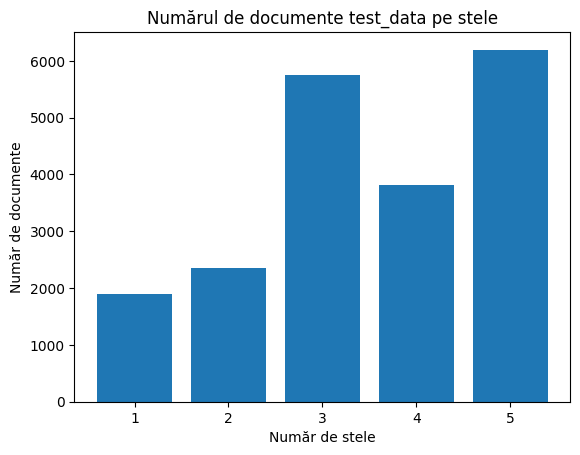

In [32]:
!pip install matplotlib
import matplotlib.pyplot as plt

# Datele pentru grafic
stars = [1, 2, 3, 4, 5]
counts = [len(test_data[i]) for i in stars]

# Crearea graficului
plt.bar(stars, counts)

# Adăugarea titlului și etichetelor axelor
plt.title("Numărul de documente test_data pe stele")
plt.xlabel("Număr de stele")
plt.ylabel("Număr de documente")

# Afișarea graficului
plt.show()

In [33]:
# Presupunând că 'test_data' și 'raw_data' sunt definite și accesibile

def calculate_sentiment_counts(data):
    """Calculează numărul total de documente, pozitive și negative."""
    total_docs = sum(len(data[i]) for i in range(1, 6))
    positive_docs = sum(len(data[i]) for i in range(1, 4))
    negative_docs = sum(len(data[i]) for i in range(4, 6))
    return total_docs, positive_docs, negative_docs

# Calculează pentru test_data
test_total, test_positive, test_negative = calculate_sentiment_counts(test_data)
print(f"test_data - Total documente: {test_total}")
print(f"test_data - Documente pozitive (1, 2, 3 stele): {test_positive}")
print(f"test_data - Documente negative (4, 5 stele): {test_negative}")

# Calculează pentru raw_data
raw_total, raw_positive, raw_negative = calculate_sentiment_counts(raw_data)
print(f"raw_data - Total documente: {raw_total}")
print(f"raw_data - Documente pozitive (1, 2, 3 stele): {raw_positive}")
print(f"raw_data - Documente negative (4, 5 stele): {raw_negative}")

test_data - Total documente: 20006
test_data - Documente pozitive (1, 2, 3 stele): 10001
test_data - Documente negative (4, 5 stele): 10005
raw_data - Total documente: 20006
raw_data - Documente pozitive (1, 2, 3 stele): 10001
raw_data - Documente negative (4, 5 stele): 10005


250
{'avut', 'nou', 'treia', 'mă', 'or', 'm', 'ma', 'nostru', 'trei', 'iti', 'său', 'avea', 'vouă', 'sub', 'aceasta', 'te', 'mi', 'dă', 'prima', 'prin', 'îl', 'acel', 'tine', 'eu', 'niste', 'la', 'aceşti', 'nimic', 'dată', 'noi', 'ori', 'atare', 'ar', 'doilea', 'dar', 'noştri', 'avem', 'daca', 'ii', 'voastre', 'unul', 'are', 'spre', 'aş', 'spate', 'acea', 'atat', 'alti', 'sa-ti', 'ne', 'alt', 'uneia', 'săi', 'noua', 'acestei', 'ului', 'cu', 'parca', 'celor', 'pot', 'asta', 'dat', 'vi', 'face', 'fii', 'undeva', 'ni', 'aceştia', 'carora', 'cel', 'astea', 'ăla', 'ca', 'i', 'il', 'oricum', 'cumva', 'lângă', 'sunteţi', 'citeva', 'unor', 'suntem', 'acela', 'doi', 'el', 'cele', 'această', 'fata', 'căror', 'in', 'atunci', 'vor', 'vreo', 'ei', 'cea', 'aibă', 'unii', 'acei', 'fiu', 'isi', 'cărei', 'care', 'abia', 'cei', 'două', 'voi', 'pe', 'aveţi', 'ceea', 'până', 'câtva', 'fim', 'acele', 'v', 'peste', 'sus', 'sale', 'ti', 'căci', 'este', 'tu', 'al', 'acest', 'cind', 'dintr', 'era', 'nu', 'dint

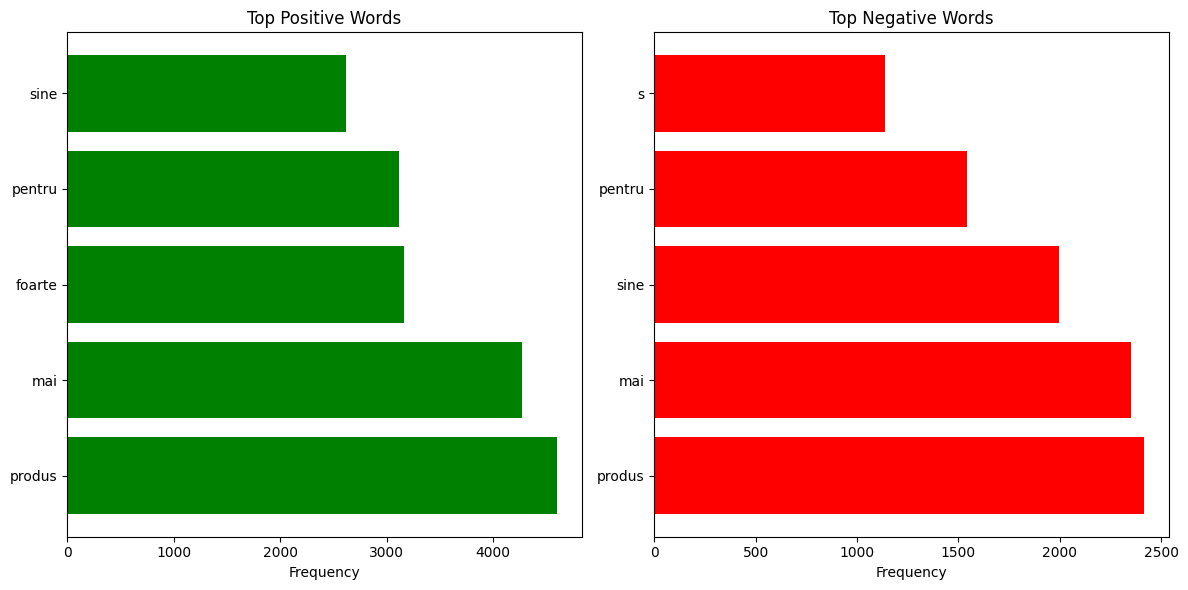

Unique to positive: 1370 words
Unique to negative: 829 words
Shared words: 2626 words
Total words: 4825 words


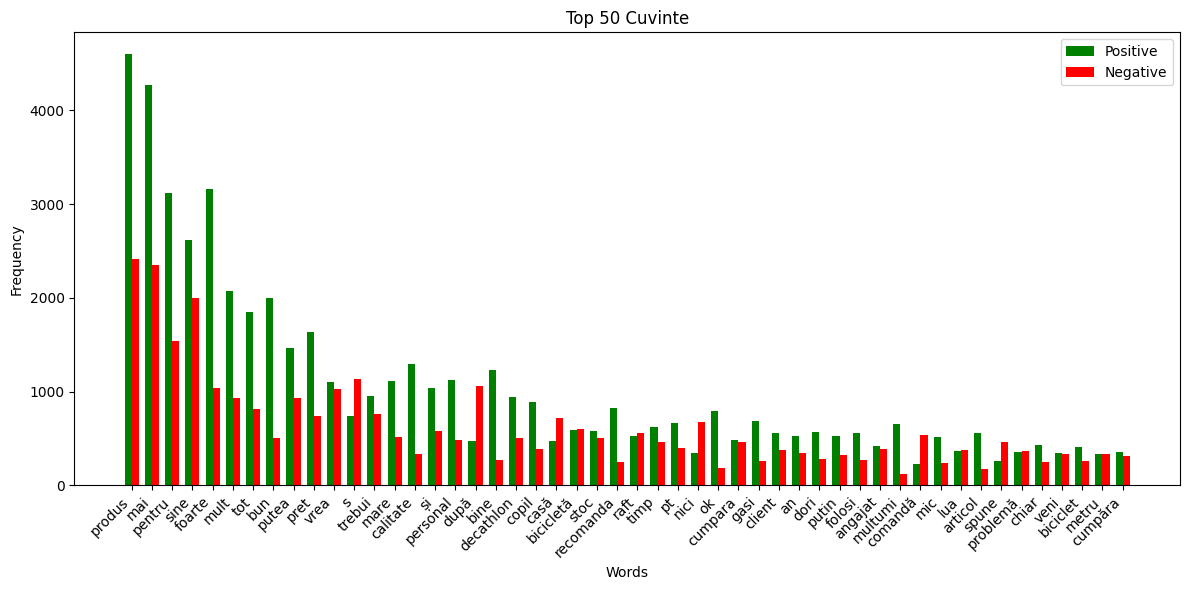

In [34]:


# # Example vocabularies (you should replace these with your actual vocs)
# voc_pos = Counter({'good': 100, 'great': 80, 'excellent': 60, 'happy': 50, 'love': 40, 'awesome': 30})
# voc_neg = Counter({'bad': 120, 'terrible': 90, 'poor': 70, 'sad': 60, 'hate': 50, 'awful': 40})
# Filter vocabularies to keep only words with at least 3 occurrences
# Assuming 'to_remove' is a list of stopwords
to_remove_set = set(rem_words(5*10))  # Convert to set for faster lookups

print(to_remove_set)

# Filter vocabularies to keep words with at least 3 occurrences and remove stopwords
voc_pos = Counter({word: count for word, count in dict_pos.items() if count >= 3 and word not in to_remove_set})
voc_neg = Counter({word: count for word, count in dict_neg.items() if count >= 3 and word not in to_remove_set})



# 1. Top frequent words
def plot_top_words(voc_pos, voc_neg, top_n=5):
    # Get top N words from each vocabulary
    top_pos = voc_pos.most_common(top_n)
    top_neg = voc_neg.most_common(top_n)

    # Words and counts for positive vocabulary
    words_pos, counts_pos = zip(*top_pos)

    # Words and counts for negative vocabulary
    words_neg, counts_neg = zip(*top_neg)

    # Bar plot for top words
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].barh(words_pos, counts_pos, color='green')
    ax[0].set_title('Top Positive Words')
    ax[0].set_xlabel('Frequency')

    ax[1].barh(words_neg, counts_neg, color='red')
    ax[1].set_title('Top Negative Words')
    ax[1].set_xlabel('Frequency')

    plt.tight_layout()
    plt.show()

# 2. Unique vs. Shared Words
def compare_unique_shared(voc_pos, voc_neg):
    pos_words = set(voc_pos.keys())
    neg_words = set(voc_neg.keys())

    # Words unique to positive and negative vocabularies
    unique_pos = pos_words - neg_words
    unique_neg = neg_words - pos_words

    # Shared words
    shared_words = pos_words & neg_words

    # Total words (count unique words only once by using the union)
    total_words = pos_words | neg_words

    print(f"Unique to positive: {len(unique_pos)} words")
    print(f"Unique to negative: {len(unique_neg)} words")
    print(f"Shared words: {len(shared_words)} words")
    print(f"Total words: {len(total_words)} words")

    return unique_pos, unique_neg, shared_words

# 3. Word Cloud (Alternative: Bar plot)
def plot_shared_words(voc_pos, voc_neg, shared_words, top_n=50):
    # Calculate the average frequency of each shared word in both vocabularies

    shared_words=voc_pos.keys() & voc_neg.keys()
    shared_avg_freq = {word: (voc_pos.get(word, 0) + voc_neg.get(word, 0)) / 2 for word in shared_words}

    # Sort the shared words by their average frequency and select the top_n words
    top_shared_words = sorted(shared_avg_freq, key=shared_avg_freq.get, reverse=True)[:top_n]

    # Get the counts for the top shared words
    shared_counts_pos = [voc_pos[word] for word in top_shared_words]
    shared_counts_neg = [voc_neg[word] for word in top_shared_words]

    x = np.arange(len(top_shared_words))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot shared word frequencies for positive and negative
    ax.bar(x - width/2, shared_counts_pos, width, label='Positive', color='green')
    ax.bar(x + width/2, shared_counts_neg, width, label='Negative', color='red')

    ax.set_xticks(x)
    ax.set_xticklabels(top_shared_words, rotation=45, ha="right")
    ax.legend()

    # titlu in engleza pentru a evita diacritice
    plt.title(f'Top {top_n} Cuvinte')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# 1. Plot top words for both vocabularies
plot_top_words(voc_pos, voc_neg, top_n=5)

# 2. Compare unique and shared words
unique_pos, unique_neg, shared_words = compare_unique_shared(voc_pos, voc_neg)

# 3. Plot shared word frequencies
plot_shared_words(voc_pos, voc_neg, shared_words)


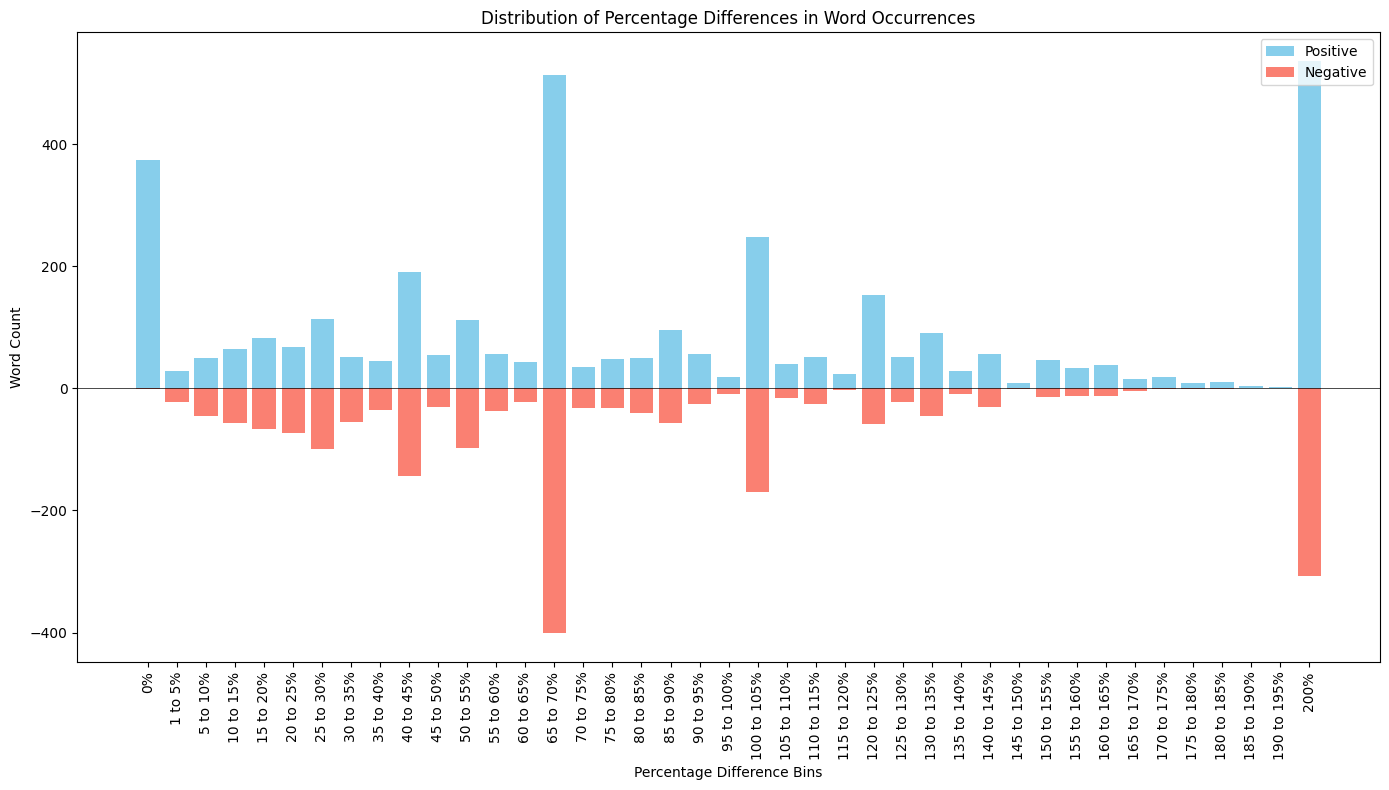

In [54]:
# Filter percentage_difference to include only words with at least 3 appearances
filtered_percentage_difference = {
    word: diff for word, diff in percentage_difference.items()
    if sum(sorted_merged_dict[word]) >= 3
}

# Define bins from just above 0% to just below 200%
bins = np.array([1, *np.arange(5, 200, 5)])
bin_labels = ["0%"] + [f"{bins[i]} to {bins[i+1]}%" for i in range(len(bins)-1)] + ["200%"]

# Initialize dictionaries to count positive and negative occurrences in each bin
positive_counts = {label: 0 for label in bin_labels}
negative_counts = {label: 0 for label in bin_labels}

# Separate handling for exact 0% and 200%
for word, diff in filtered_percentage_difference.items():
    abs_diff = abs(diff)

    # Special handling for exactly 0% and exactly 200%
    if abs_diff == 0:
        bin_label = "0%"
    elif abs_diff == 200:
        bin_label = "200%"
    else:
        # Use digitize for values within (0, 200)
        bin_index = np.digitize(abs_diff, bins)
        bin_label = bin_labels[bin_index]

    # Update counts based on positive or negative difference
    if diff >= 0:
        positive_counts[bin_label] += 1
    else:
        negative_counts[bin_label] += 1

# Convert counts to lists for plotting
positive_counts_values = list(positive_counts.values())
negative_counts_values = [-count for count in negative_counts.values()]  # Negative for plotting below axis

# Plot the bar chart with positive and negative counts centered on each x-axis tick
x = np.arange(len(bin_labels))  # x-axis positions for each bin

plt.figure(figsize=(14, 8))
plt.bar(x, positive_counts_values, color='skyblue', label="Positive")
plt.bar(x, negative_counts_values, color='salmon', label="Negative")
plt.xticks(x, bin_labels, rotation=90)  # Set x-ticks to bin labels and rotate for readability
plt.axhline(0, color='black', linewidth=0.5)  # Add a baseline at y=0
plt.xlabel("Percentage Difference Bins")
plt.ylabel("Word Count")
plt.title("Distribution of Percentage Differences in Word Occurrences")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


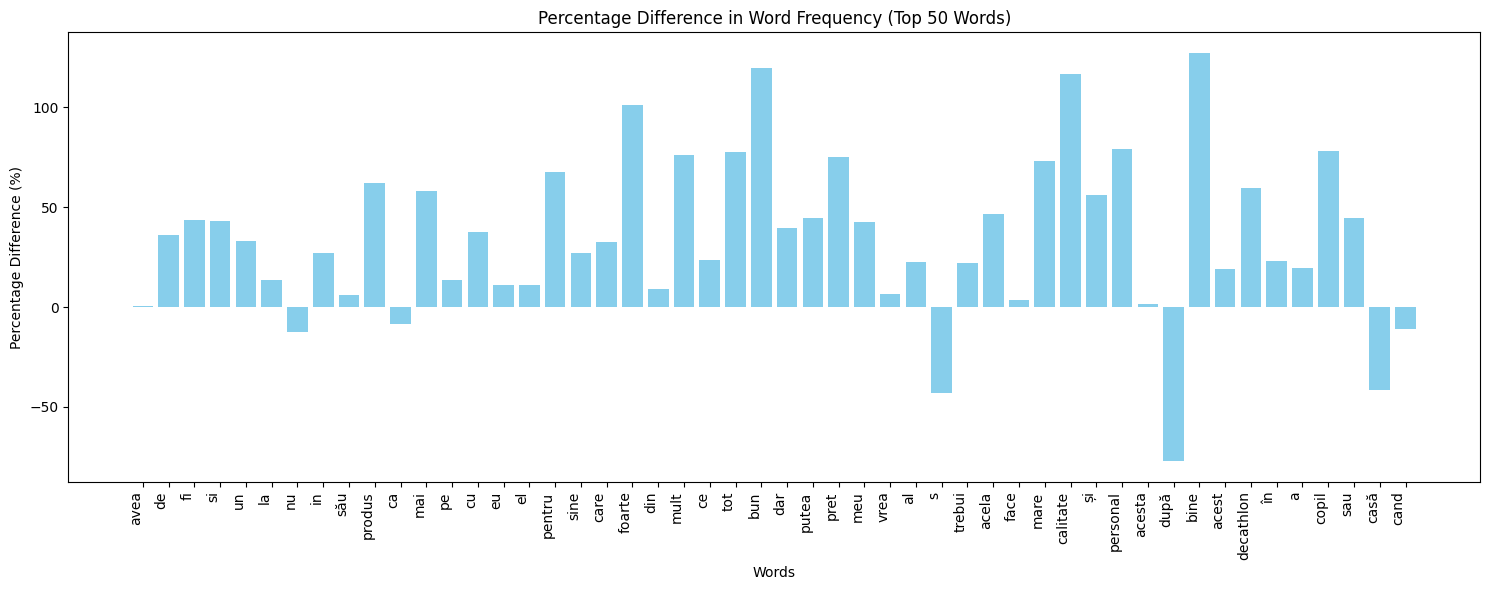

In [37]:

# Assuming 'percentage_difference' and 'sorted_merged_dict' are defined

# Get the top 50 words and their percentage differences
top_50_words = list(percentage_difference.keys())[:50]
top_50_percentages = [percentage_difference[word] for word in top_50_words]

# Create the bar plot
plt.figure(figsize=(15, 6))  # Adjust figure size for better readability
plt.bar(top_50_words, top_50_percentages, color='skyblue')

# Customize the plot
plt.title("Percentage Difference in Word Frequency (Top 50 Words)")
plt.xlabel("Words")
plt.ylabel("Percentage Difference (%)")
plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

# Display the plot
plt.show()